In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import anndata
import os
import scanpy as sc
from tqdm import tqdm
from matplotlib.colors import rgb2hex
import random
import tangram as tg
import torch
from scipy import stats
import warnings
from PIL import Image
from sklearn.metrics import mean_squared_error

In [3]:
from src.loki.plotting.pie_plot import *
from src.loki.plotting.xenium_plot import *
from src.loki.tools.pca_fit import *
from src.loki.tools.loki_deconv import *

In [4]:
def generate_sc_feature_ad(sc_data, case_name):
    sc_text_feature_path = os.path.join(data_path, sample_name+'_txt_features_sc'+case_name+'.csv')
    sc_text_features = pd.read_csv(sc_text_feature_path, index_col=0)[sc_data.obs.index]
    sc_ad_emb = anndata.AnnData(sc_text_features.T)
    sc_ad_emb.obs = sc_data.obs.copy()
    
    return sc_ad_emb

In [5]:
def generate_st_text_feature_ad(ad_expr, case_name):
    text_feature_path = os.path.join(data_path, sample_name+'_txt_features'+case_name+'.csv')
    text_features = pd.read_csv(text_feature_path, index_col=0)[ad_expr.obs.index]
    txt_ad = anndata.AnnData(text_features[ad_expr.obs.index].T)
    txt_ad.obs['cell_num']=ad_expr.obs['cell_num'].copy()
    txt_ad.uns['spatial']=ad_expr.uns['spatial'].copy()
    txt_ad.obsm['spatial']=ad_expr.obsm['spatial'].copy()
    
    return txt_ad

In [6]:
def generate_st_image_feature_ad(ad_expr, case_name):
    image_feature_path = os.path.join(data_path, sample_name+'_img_features'+case_name+'.csv')
    image_features = pd.read_csv(image_feature_path, index_col=0)[ad_expr.obs.index]
    img_ad = anndata.AnnData(image_features[ad_expr.obs.index].T)
    img_ad.obs['cell_num']=ad_expr.obs['cell_num'].copy()
    img_ad.uns['spatial']=ad_expr.uns['spatial'].copy()
    img_ad.obsm['spatial']=ad_expr.obsm['spatial'].copy()
    return img_ad

In [22]:
def generate_deconv_df(sc_ad, st_ad):
    for cell_type in st_ad.obsm['tangram_ct_pred'].columns:
        st_ad.obsm['tangram_ct_pred'][cell_type]=st_ad.obsm['tangram_ct_pred'][cell_type]*sc_ad.obs['cell_type'].value_counts()[cell_type]
    
    st_ad.obsm['tangram_ct_pred']['Immune']=st_ad.obsm['tangram_ct_pred']['Macrophage']+ \
                                                st_ad.obsm['tangram_ct_pred']['B cell'] + \
                                                st_ad.obsm['tangram_ct_pred']['T cell']
    st_ad.obsm['tangram_ct_pred'].drop(['Macrophage','B cell','T cell'],axis=1, inplace=True)
    st_ad.obsm['tangram_ct_pred'] = st_ad.obsm['tangram_ct_pred'][['Epithelial', 'Immune', 'Stroma']]
          
    deconv_df = st_ad.obsm['tangram_ct_pred'].T/st_ad.obsm['tangram_ct_pred'].T.sum()
    deconv_df = deconv_df.T

    return deconv_df

In [24]:
def calculate_psr(psr, column, raw_deconv, deconv_df):
    psr.loc[column, 'Epithelial'] = stats.pearsonr(raw_deconv['Epithelial'], deconv_df['Epithelial'])[0]
    psr.loc[column, 'Immune'] = stats.pearsonr(raw_deconv['Immune'], deconv_df['Immune'])[0]
    psr.loc[column, 'Stroma'] = stats.pearsonr(raw_deconv['Stroma'], deconv_df['Stroma'])[0]
    return psr

In [28]:
def calculate_mse(mse, column, raw_deconv, deconv_df):
    mse.loc[column, 'Epithelial'] = mean_squared_error(raw_deconv['Epithelial'], deconv_df['Epithelial'])
    mse.loc[column, 'Stroma'] = mean_squared_error(raw_deconv['Stroma'], deconv_df['Stroma'])
    mse.loc[column, 'Immune']  = mean_squared_error(raw_deconv['Immune'], deconv_df['Immune'])
    return mse

In [8]:
data_path = '/condo/wanglab/shared/wxc/clip/data/human/HM_data/TNBC/'

In [9]:
sample_name = 'TNBC_processed_adata_raw'

In [139]:
sc_data_raw = sc.read_h5ad(data_path + 'TNBC_SC_preprocess.h5ad')
ad_vis = sc.read_h5ad(data_path +'TNBC_Xenium_psd_3402.h5ad')
ad_xen_sp = sc.read_h5ad(data_path+'TNBC_Xenium_celltype_spot.h5ad')

In [11]:
density_prior=np.array(ad_vis.obs['cell_num']) / ad_vis.obs['cell_num'].sum()

In [12]:
raw_deconv = ad_xen_sp.obs.pivot_table(index='spot', columns='cell_type', aggfunc='size').reindex(ad_vis.obs.index).T
raw_deconv = raw_deconv/raw_deconv.sum(axis=0)
raw_deconv = raw_deconv.T
raw_deconv

cell_type                                Epithelial    Immune    Stroma
TNBC_processed_adata_AACACGTGCATCGCAC-1    0.000000  1.000000  0.000000
TNBC_processed_adata_AACACTTGGCAAGGAA-1    0.750000  0.250000  0.000000
TNBC_processed_adata_AACAGGAAGAGCATAG-1    0.772727  0.000000  0.227273
TNBC_processed_adata_AACAGGATTCATAGTT-1    0.916667  0.083333  0.000000
TNBC_processed_adata_AACAGGTTATTGCACC-1    0.846154  0.153846  0.000000
...                                             ...       ...       ...
TNBC_processed_adata_TGTTGGAACCTTCCGC-1    1.000000  0.000000  0.000000
TNBC_processed_adata_TGTTGGAACGAGGTCA-1    0.968750  0.000000  0.031250
TNBC_processed_adata_TGTTGGAAGCTCGGTA-1    0.793103  0.000000  0.206897
TNBC_processed_adata_TGTTGGATGGACTTCT-1    1.000000  0.000000  0.000000
TNBC_processed_adata_TGTTGGCCTACACGTG-1    0.800000  0.200000  0.000000

[3402 rows x 3 columns]

In [159]:
psr = pd.DataFrame()
mse = pd.DataFrame()

# Xenium Component

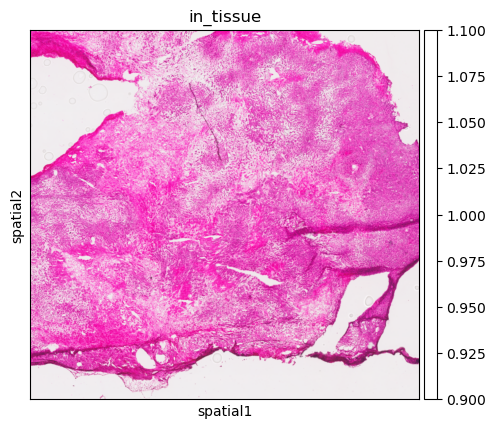

In [14]:
sc.pl.spatial(ad_vis, color='in_tissue', alpha=0)

In [140]:
ad_vis_copy=ad_vis.copy()
ad_vis_copy.obs = pd.concat([ad_vis_copy.obs,raw_deconv],axis=1)

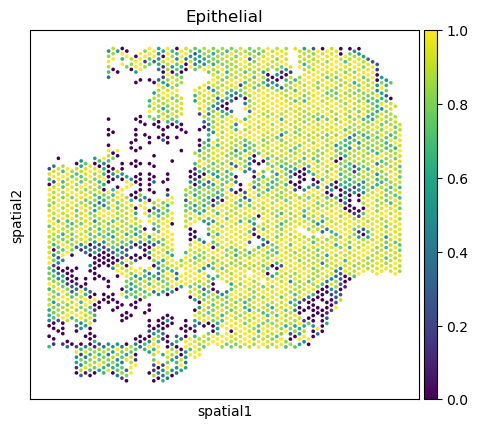

In [16]:
sc.pl.spatial(ad_vis, color='Epithelial', alpha_img=0)

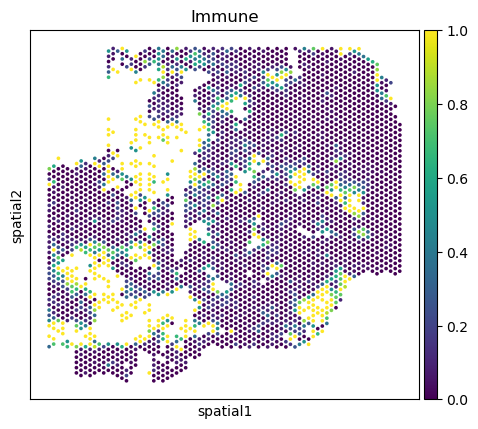

In [18]:
sc.pl.spatial(ad_vis, color='Immune', alpha_img=0)

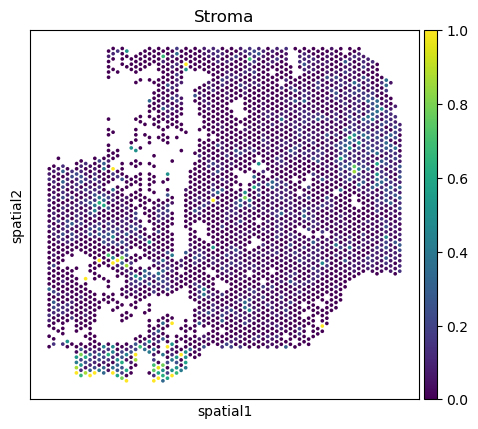

In [19]:
sc.pl.spatial(ad_vis, color='Stroma', alpha_img=0)

In [603]:
# data = np.array(deconv_df.T)
# coordinates = np.array([ad_vis.obsm['spatial'][:, 0], -ad_vis.obsm['spatial'][:, 1]]).T/ad_vis.obsm['spatial'].max()
# colors = ['#FFFF00', '#ED0DD9', '#BBF90F']
# plt_pie_chart(data, coordinates, colors)

# Deconv

## Tangram

In [160]:
ad_expr = ad_vis.copy()
sc.pp.normalize_total(ad_expr)
sc.pp.log1p(ad_expr)

In [161]:
sc_data = sc_data_raw.copy()
sc.pp.normalize_total(sc_data)
sc.pp.log1p(sc_data)

In [162]:
sc.pp.highly_variable_genes(sc_data)
genes = sc_data.var[sc_data.var.highly_variable].index.tolist()
len(genes)

3279

In [163]:
# sc.tl.rank_genes_groups(sc_data, groupby="cell_type", use_raw=False)
# # markers_df = pd.DataFrame(sc_data.uns["rank_genes_groups"]["names"]).iloc[0:30, :]
# markers_df = pd.DataFrame(sc_data.uns["rank_genes_groups"]["names"]).iloc[0:100, :]
# genes_sc = np.unique(markers_df.melt().value.values)
# genes_st = ad_expr.var_names.values
# genes = list(set(genes_sc).intersection(set(genes_st)))
# len(genes)

In [164]:
# tg.pp_adatas(sc_data, ad_expr, genes=genes)
tg.pp_adatas(sc_data, ad_expr, genes=None)
ad_map = tg.map_cells_to_space(sc_data, ad_expr, 
    mode='clusters',
    cluster_label='cell_type',
    device='cpu',
    target_count=ad_expr.obs['cell_num'].sum(),
    # density_prior=torch.from_numpy(density_prior),
    scale=False,
    random_state=10
)
tg.project_cell_annotations(ad_map, ad_expr, annotation='cell_type')

INFO:root:272 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:272 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 272 genes and rna_count_based density_prior in clusters mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.481, KL reg: 0.307
Score: 0.663, KL reg: 0.000
Score: 0.663, KL reg: 0.000
Score: 0.663, KL reg: 0.000
Score: 0.663, KL reg: 0.000
Score: 0.663, KL reg: 0.000
Score: 0.663, KL reg: 0.000
Score: 0.663, KL reg: 0.000
Score: 0.663, KL reg: 0.000
Score: 0.663, KL reg: 0.000


INFO:root:Saving results..
INFO:root:spatial prediction dataframe is saved in `obsm` `tangram_ct_pred` of the spatial AnnData.


In [165]:
deconv_df = generate_deconv_df(sc_data, ad_expr)
psr = calculate_psr(psr, 'tangram', raw_deconv, deconv_df)
mse = calculate_mse(mse, 'tangram', raw_deconv, deconv_df)

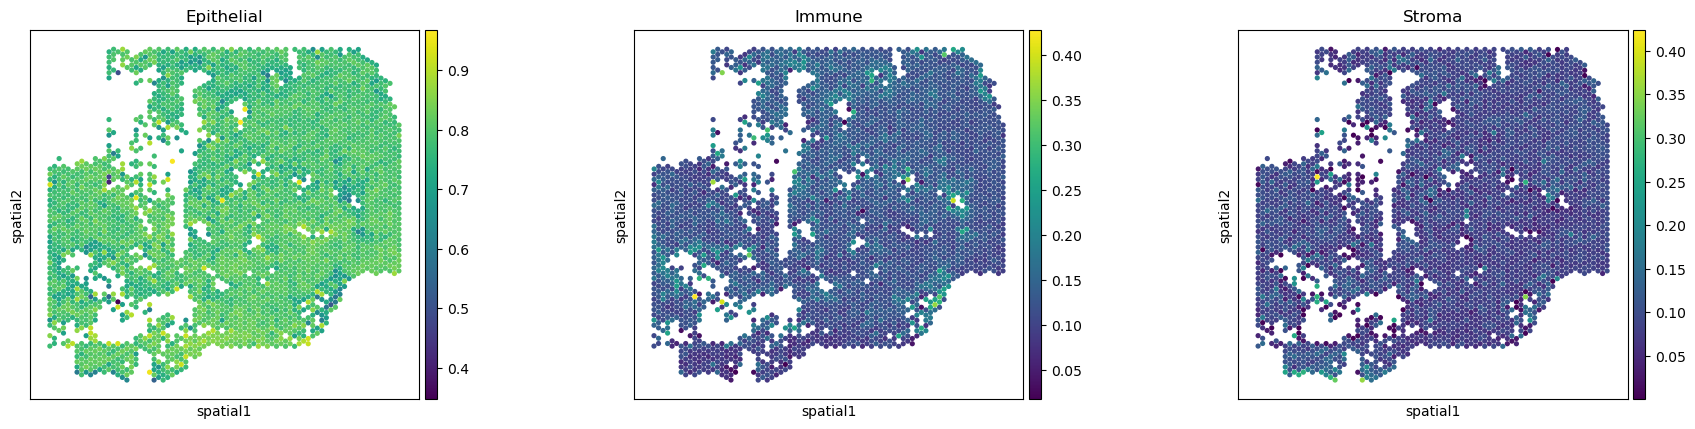

In [166]:
ad_expr.obs = pd.concat([ad_expr.obs, deconv_df],axis=1)
sc.pl.spatial(ad_expr, color=['Epithelial','Immune','Stroma'], alpha_img=0, spot_size=400)

## OmiCLIP

### Before finetune

In [169]:
case_name = '_training20_psd'

In [170]:
ad_expr = ad_vis.copy()
sc_data = sc_data_raw.copy()

#### txt

In [171]:
sc_ad_emb = generate_sc_feature_ad(sc_data, case_name)
txt_ad = generate_st_text_feature_ad(ad_expr, case_name)

In [172]:
txt_ad = cell_type_deconvolution(sc_ad_emb, txt_ad, density_prior)

INFO:root:299 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:299 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 299 genes and tensor([1.8325e-05, 2.1991e-04, 4.0316e-04,  ..., 5.3144e-04, 1.6493e-04,
        9.1627e-05], dtype=torch.float64) density_prior in clusters mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.006, KL reg: 0.471
Score: 0.061, KL reg: 0.000
Score: 0.065, KL reg: 0.000
Score: 0.065, KL reg: 0.000
Score: 0.066, KL reg: 0.000
Score: 0.066, KL reg: 0.000
Score: 0.066, KL reg: 0.000
Score: 0.066, KL reg: 0.000
Score: 0.066, KL reg: 0.000
Score: 0.066, KL reg: 0.000


INFO:root:Saving results..
INFO:root:spatial prediction dataframe is saved in `obsm` `tangram_ct_pred` of the spatial AnnData.


In [173]:
deconv_df = generate_deconv_df(sc_ad_emb, txt_ad)
psr = calculate_psr(psr, 'txt_zs', raw_deconv, deconv_df)
mse = calculate_mse(mse, 'txt_zs', raw_deconv, deconv_df)

#### img

In [176]:
sc_ad_emb = generate_sc_feature_ad(sc_data, case_name)
img_ad = generate_st_image_feature_ad(ad_expr, case_name)

In [177]:
img_ad = cell_type_deconvolution(sc_ad_emb, img_ad, density_prior)

INFO:root:277 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:277 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 277 genes and tensor([1.8325e-05, 2.1991e-04, 4.0316e-04,  ..., 5.3144e-04, 1.6493e-04,
        9.1627e-05], dtype=torch.float64) density_prior in clusters mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.050, KL reg: 0.471
Score: 0.121, KL reg: 0.001
Score: 0.131, KL reg: 0.001
Score: 0.132, KL reg: 0.001
Score: 0.132, KL reg: 0.001
Score: 0.132, KL reg: 0.000
Score: 0.132, KL reg: 0.000
Score: 0.132, KL reg: 0.000
Score: 0.132, KL reg: 0.000
Score: 0.132, KL reg: 0.000


INFO:root:Saving results..
INFO:root:spatial prediction dataframe is saved in `obsm` `tangram_ct_pred` of the spatial AnnData.


In [178]:
deconv_df = generate_deconv_df(sc_ad_emb, img_ad)
psr = calculate_psr(psr, 'img_zs', raw_deconv, deconv_df)
mse = calculate_mse(mse, 'img_zs', raw_deconv, deconv_df)

In [179]:
img_ad.obs = pd.concat([img_ad.obs, deconv_df],axis=1)

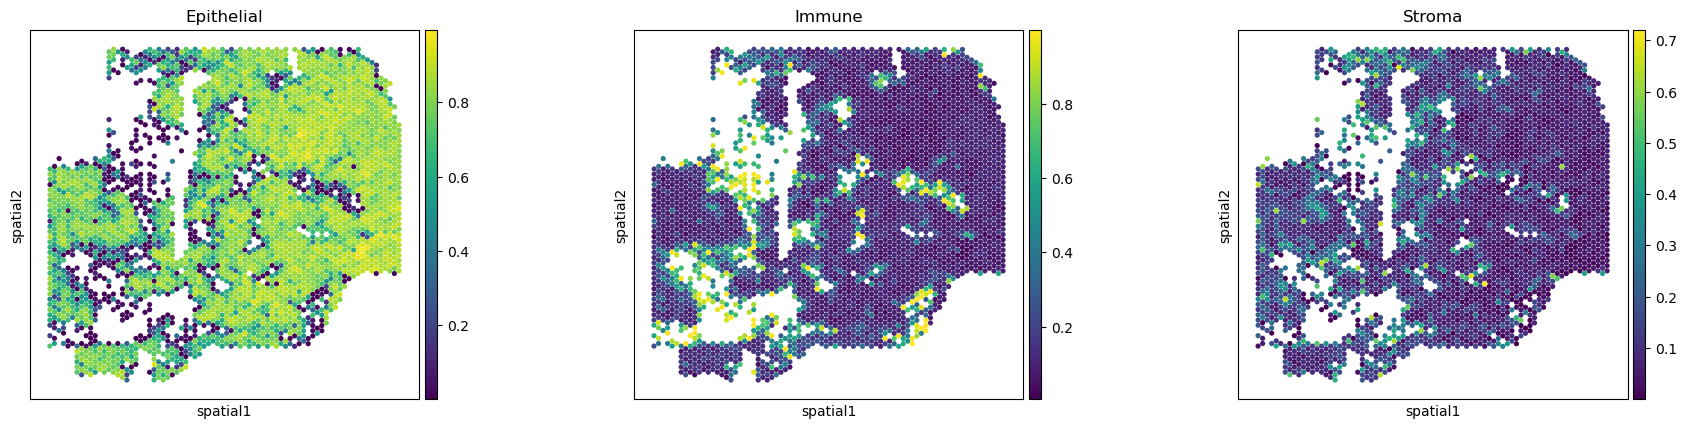

In [180]:
sc.pl.spatial(img_ad, color=['Epithelial','Immune','Stroma'], alpha_img=0, spot_size=400)

### After finetune rb

In [181]:
case_name = '_finetune10_rb_psd'

In [182]:
ad_expr = ad_vis.copy()
sc_data = sc_data_raw.copy()

#### txt

In [183]:
sc_ad_emb = generate_sc_feature_ad(sc_data, case_name)
txt_ad = generate_st_text_feature_ad(ad_expr, case_name)

In [184]:
txt_ad = cell_type_deconvolution(sc_ad_emb, txt_ad, density_prior)

INFO:root:300 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:300 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 300 genes and tensor([1.8325e-05, 2.1991e-04, 4.0316e-04,  ..., 5.3144e-04, 1.6493e-04,
        9.1627e-05], dtype=torch.float64) density_prior in clusters mode...
INFO:root:Printing scores every 100 epochs.


Score: -0.008, KL reg: 0.471
Score: 0.049, KL reg: 0.000
Score: 0.052, KL reg: 0.000
Score: 0.053, KL reg: 0.000
Score: 0.054, KL reg: 0.000
Score: 0.054, KL reg: 0.000
Score: 0.054, KL reg: 0.000
Score: 0.054, KL reg: 0.000
Score: 0.054, KL reg: 0.000
Score: 0.054, KL reg: 0.000


INFO:root:Saving results..
INFO:root:spatial prediction dataframe is saved in `obsm` `tangram_ct_pred` of the spatial AnnData.


In [185]:
deconv_df = generate_deconv_df(sc_ad_emb, txt_ad)
psr = calculate_psr(psr, 'txt_rb', raw_deconv, deconv_df)
mse = calculate_mse(mse, 'txt_rb', raw_deconv, deconv_df)

#### img

In [186]:
sc_ad_emb = generate_sc_feature_ad(sc_data, case_name)
img_ad = generate_st_image_feature_ad(ad_expr, case_name)

In [187]:
img_ad = cell_type_deconvolution(sc_ad_emb, img_ad, density_prior)

INFO:root:298 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:298 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 298 genes and tensor([1.8325e-05, 2.1991e-04, 4.0316e-04,  ..., 5.3144e-04, 1.6493e-04,
        9.1627e-05], dtype=torch.float64) density_prior in clusters mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.007, KL reg: 0.471
Score: 0.061, KL reg: 0.000
Score: 0.063, KL reg: 0.000
Score: 0.064, KL reg: 0.000
Score: 0.064, KL reg: 0.000
Score: 0.064, KL reg: 0.000
Score: 0.064, KL reg: 0.000
Score: 0.064, KL reg: 0.000
Score: 0.065, KL reg: 0.000
Score: 0.065, KL reg: 0.000


INFO:root:Saving results..
INFO:root:spatial prediction dataframe is saved in `obsm` `tangram_ct_pred` of the spatial AnnData.


In [188]:
deconv_df = generate_deconv_df(sc_ad_emb, img_ad)
psr = calculate_psr(psr, 'img_rb', raw_deconv, deconv_df)
mse = calculate_mse(mse, 'img_rb', raw_deconv, deconv_df)

In [56]:
img_ad.obs = pd.concat([img_ad.obs, deconv_df],axis=1)

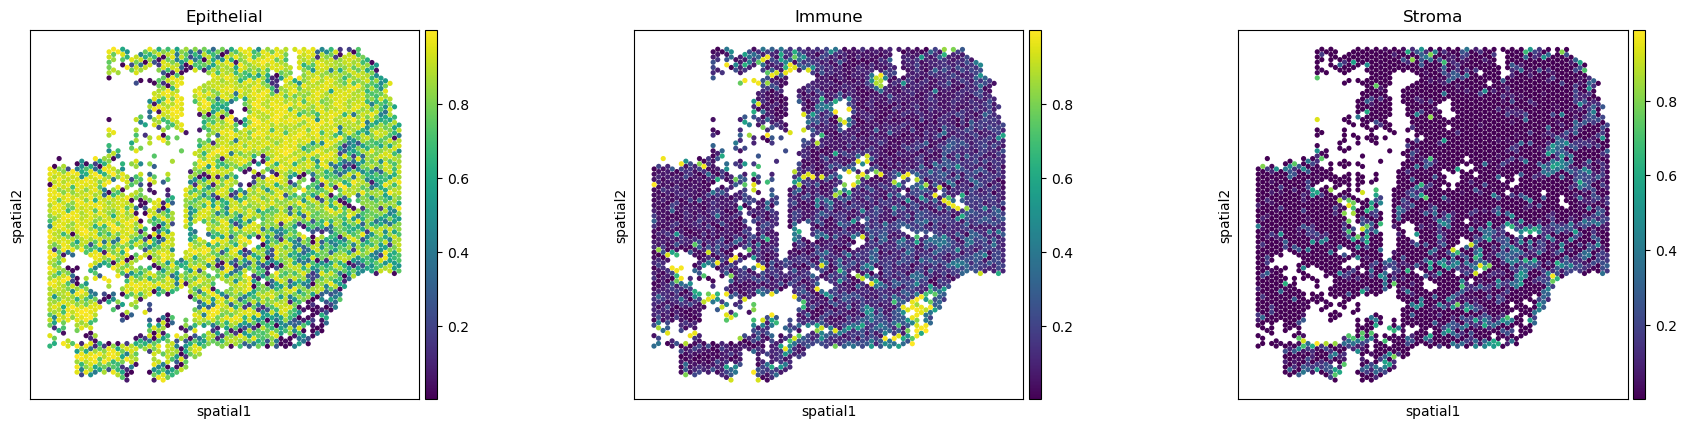

In [57]:
sc.pl.spatial(img_ad, color=['Epithelial','Immune','Stroma'], alpha_img=0, spot_size=400)

### After finetune rt

In [189]:
case_name = '_finetune10_rt_psd'

In [190]:
ad_expr = ad_vis.copy()
sc_data = sc_data_raw.copy()

#### txt

In [191]:
sc_ad_emb = generate_sc_feature_ad(sc_data, case_name)
txt_ad = generate_st_text_feature_ad(ad_expr, case_name)

In [192]:
txt_ad = cell_type_deconvolution(sc_ad_emb, txt_ad, density_prior)

INFO:root:300 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:300 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 300 genes and tensor([1.8325e-05, 2.1991e-04, 4.0316e-04,  ..., 5.3144e-04, 1.6493e-04,
        9.1627e-05], dtype=torch.float64) density_prior in clusters mode...
INFO:root:Printing scores every 100 epochs.


Score: -0.016, KL reg: 0.471
Score: 0.036, KL reg: 0.000
Score: 0.040, KL reg: 0.000
Score: 0.041, KL reg: 0.000
Score: 0.041, KL reg: 0.000
Score: 0.042, KL reg: 0.000
Score: 0.042, KL reg: 0.000
Score: 0.042, KL reg: 0.000
Score: 0.042, KL reg: 0.000
Score: 0.043, KL reg: 0.000


INFO:root:Saving results..
INFO:root:spatial prediction dataframe is saved in `obsm` `tangram_ct_pred` of the spatial AnnData.


In [193]:
deconv_df = generate_deconv_df(sc_ad_emb, txt_ad)
psr = calculate_psr(psr, 'txt_rt', raw_deconv, deconv_df)
mse = calculate_mse(mse, 'txt_rt', raw_deconv, deconv_df)

#### img

In [194]:
sc_ad_emb = generate_sc_feature_ad(sc_data, case_name)
img_ad = generate_st_image_feature_ad(ad_expr, case_name)

In [195]:
img_ad = cell_type_deconvolution(sc_ad_emb, img_ad, density_prior)

INFO:root:299 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:299 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 299 genes and tensor([1.8325e-05, 2.1991e-04, 4.0316e-04,  ..., 5.3144e-04, 1.6493e-04,
        9.1627e-05], dtype=torch.float64) density_prior in clusters mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.015, KL reg: 0.471
Score: 0.074, KL reg: 0.000
Score: 0.077, KL reg: 0.000
Score: 0.078, KL reg: 0.000
Score: 0.078, KL reg: 0.000
Score: 0.078, KL reg: 0.000
Score: 0.078, KL reg: 0.000
Score: 0.078, KL reg: 0.000
Score: 0.078, KL reg: 0.000
Score: 0.078, KL reg: 0.000


INFO:root:Saving results..
INFO:root:spatial prediction dataframe is saved in `obsm` `tangram_ct_pred` of the spatial AnnData.


In [196]:
deconv_df = generate_deconv_df(sc_ad_emb, img_ad)
psr = calculate_psr(psr, 'img_rt', raw_deconv, deconv_df)
mse = calculate_mse(mse, 'img_rt', raw_deconv, deconv_df)

In [108]:
img_ad.obs = pd.concat([img_ad.obs, deconv_df],axis=1)

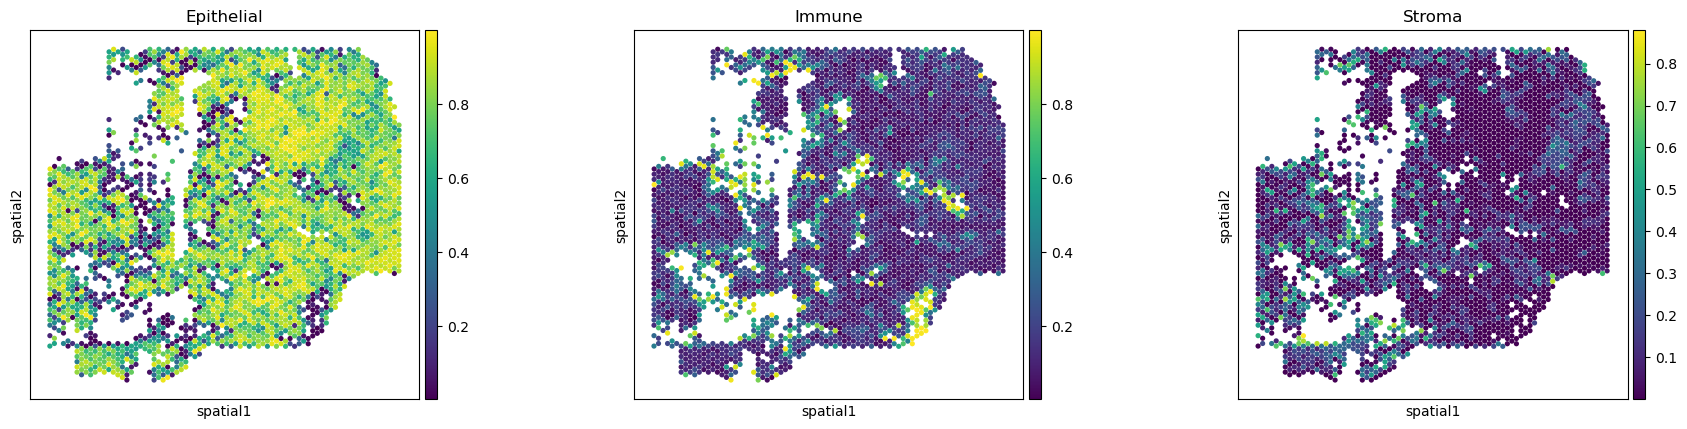

In [109]:
sc.pl.spatial(img_ad, color=['Epithelial','Immune','Stroma'], alpha_img=0, spot_size=400)

### After finetune lt

In [197]:
case_name = '_finetune10_lt_psd'

In [198]:
ad_expr = ad_vis.copy()
sc_data = sc_data_raw.copy()

#### txt

In [199]:
sc_ad_emb = generate_sc_feature_ad(sc_data, case_name)
txt_ad = generate_st_text_feature_ad(ad_expr, case_name)

In [200]:
txt_ad = cell_type_deconvolution(sc_ad_emb, txt_ad, density_prior)

INFO:root:300 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:300 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 300 genes and tensor([1.8325e-05, 2.1991e-04, 4.0316e-04,  ..., 5.3144e-04, 1.6493e-04,
        9.1627e-05], dtype=torch.float64) density_prior in clusters mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.002, KL reg: 0.471
Score: 0.052, KL reg: 0.000
Score: 0.056, KL reg: 0.000
Score: 0.058, KL reg: 0.000
Score: 0.059, KL reg: 0.000
Score: 0.059, KL reg: 0.000
Score: 0.059, KL reg: 0.000
Score: 0.059, KL reg: 0.000
Score: 0.059, KL reg: 0.000
Score: 0.059, KL reg: 0.000


INFO:root:Saving results..
INFO:root:spatial prediction dataframe is saved in `obsm` `tangram_ct_pred` of the spatial AnnData.


In [201]:
deconv_df = generate_deconv_df(sc_ad_emb, txt_ad)
psr = calculate_psr(psr, 'txt_lt', raw_deconv, deconv_df)
mse = calculate_mse(mse, 'txt_lt', raw_deconv, deconv_df)

#### img

In [202]:
sc_ad_emb = generate_sc_feature_ad(sc_data, case_name)
img_ad = generate_st_image_feature_ad(ad_expr, case_name)

In [203]:
img_ad = cell_type_deconvolution(sc_ad_emb, img_ad, density_prior)

INFO:root:296 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:296 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 296 genes and tensor([1.8325e-05, 2.1991e-04, 4.0316e-04,  ..., 5.3144e-04, 1.6493e-04,
        9.1627e-05], dtype=torch.float64) density_prior in clusters mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.019, KL reg: 0.471
Score: 0.072, KL reg: 0.001
Score: 0.076, KL reg: 0.000
Score: 0.077, KL reg: 0.000
Score: 0.078, KL reg: 0.000
Score: 0.078, KL reg: 0.000
Score: 0.078, KL reg: 0.000
Score: 0.079, KL reg: 0.001
Score: 0.079, KL reg: 0.001
Score: 0.079, KL reg: 0.001


INFO:root:Saving results..
INFO:root:spatial prediction dataframe is saved in `obsm` `tangram_ct_pred` of the spatial AnnData.


In [204]:
deconv_df = generate_deconv_df(sc_ad_emb, img_ad)
psr = calculate_psr(psr, 'img_lt', raw_deconv, deconv_df)
mse = calculate_mse(mse, 'img_lt', raw_deconv, deconv_df)

In [118]:
img_ad.obs = pd.concat([img_ad.obs, deconv_df],axis=1)

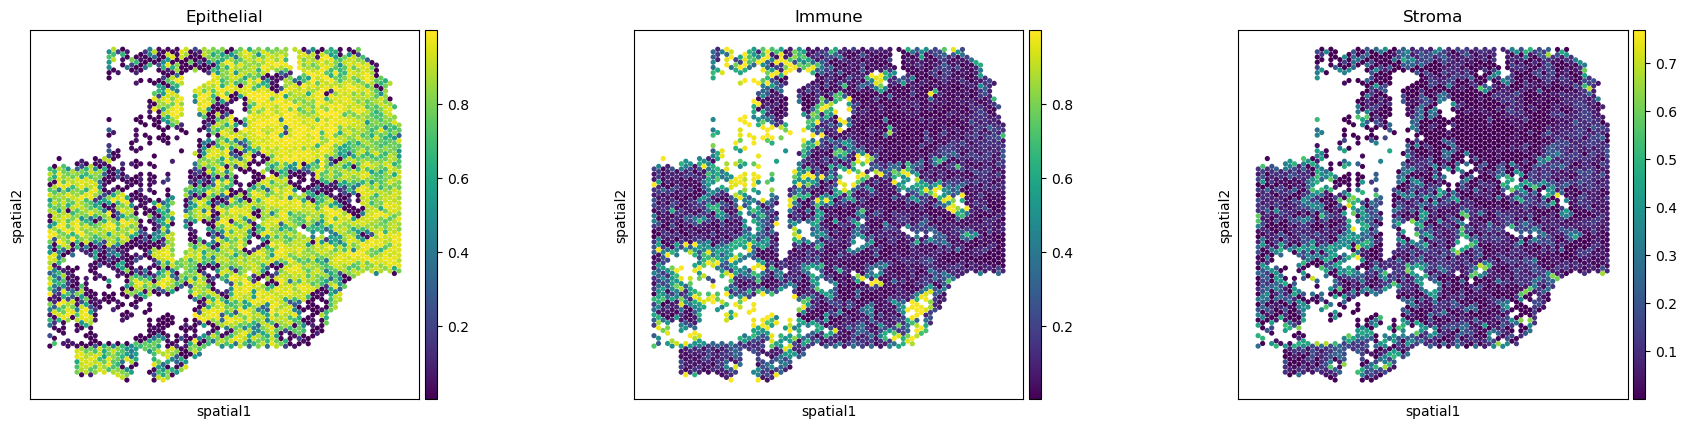

In [119]:
sc.pl.spatial(img_ad, color=['Epithelial','Immune','Stroma'], alpha_img=0, spot_size=400)

### After finetune lb

In [207]:
case_name = '_finetune10_lb_psd'

In [208]:
ad_expr = ad_vis.copy()
sc_data = sc_data_raw.copy()

#### txt

In [209]:
sc_ad_emb = generate_sc_feature_ad(sc_data, case_name)
txt_ad = generate_st_text_feature_ad(ad_expr, case_name)

In [210]:
txt_ad = cell_type_deconvolution(sc_ad_emb, txt_ad, density_prior)

INFO:root:300 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:300 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 300 genes and tensor([1.8325e-05, 2.1991e-04, 4.0316e-04,  ..., 5.3144e-04, 1.6493e-04,
        9.1627e-05], dtype=torch.float64) density_prior in clusters mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.005, KL reg: 0.471
Score: 0.067, KL reg: 0.000
Score: 0.072, KL reg: 0.000
Score: 0.073, KL reg: 0.000
Score: 0.074, KL reg: 0.000
Score: 0.074, KL reg: 0.000
Score: 0.074, KL reg: 0.000
Score: 0.074, KL reg: 0.000
Score: 0.075, KL reg: 0.000
Score: 0.075, KL reg: 0.000


INFO:root:Saving results..
INFO:root:spatial prediction dataframe is saved in `obsm` `tangram_ct_pred` of the spatial AnnData.


In [211]:
deconv_df = generate_deconv_df(sc_ad_emb, txt_ad)
psr = calculate_psr(psr, 'txt_lb', raw_deconv, deconv_df)
mse = calculate_mse(mse, 'txt_lb', raw_deconv, deconv_df)

#### img

In [212]:
sc_ad_emb = generate_sc_feature_ad(sc_data, case_name)
img_ad = generate_st_image_feature_ad(ad_expr, case_name)

In [213]:
img_ad = cell_type_deconvolution(sc_ad_emb, img_ad, density_prior)

INFO:root:298 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:298 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 298 genes and tensor([1.8325e-05, 2.1991e-04, 4.0316e-04,  ..., 5.3144e-04, 1.6493e-04,
        9.1627e-05], dtype=torch.float64) density_prior in clusters mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.030, KL reg: 0.471
Score: 0.106, KL reg: 0.001
Score: 0.110, KL reg: 0.001
Score: 0.111, KL reg: 0.001
Score: 0.111, KL reg: 0.001
Score: 0.111, KL reg: 0.001
Score: 0.111, KL reg: 0.001
Score: 0.111, KL reg: 0.001
Score: 0.111, KL reg: 0.001
Score: 0.111, KL reg: 0.001


INFO:root:Saving results..
INFO:root:spatial prediction dataframe is saved in `obsm` `tangram_ct_pred` of the spatial AnnData.


In [214]:
deconv_df = generate_deconv_df(sc_ad_emb, img_ad)
psr = calculate_psr(psr, 'img_lb', raw_deconv, deconv_df)
mse = calculate_mse(mse, 'img_lb', raw_deconv, deconv_df)

In [128]:
img_ad.obs = pd.concat([img_ad.obs, deconv_df],axis=1)

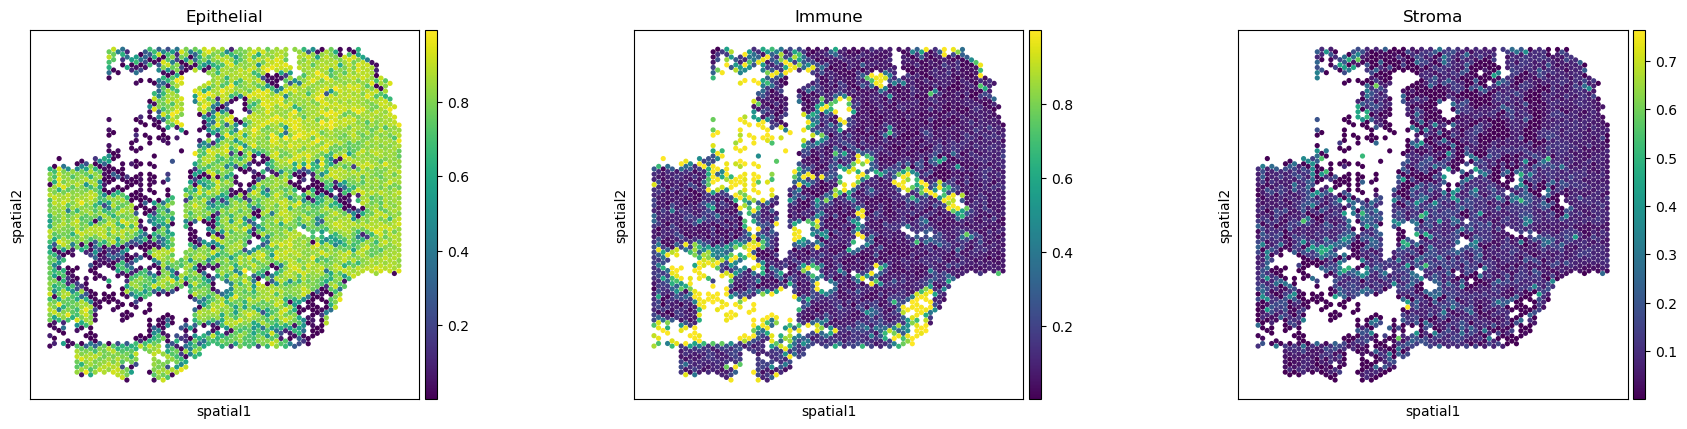

In [129]:
sc.pl.spatial(img_ad, color=['Epithelial','Immune','Stroma'], alpha_img=0, spot_size=400)

# Combined Analysis

## CARD

In [215]:
celltype_portion = pd.read_csv(data_path+"CARD/CARD_deconv_psd.csv",index_col=0)

In [216]:
celltype_portion['Immune']=celltype_portion['macrophage']+ \
                                            celltype_portion['Bcell'] + \
                                            celltype_portion['Tcell']
celltype_portion.drop(['macrophage','Bcell','Tcell'],axis=1, inplace=True)
celltype_portion = celltype_portion[['Epithelial', 'Immune', 'Stroma']]

In [217]:
psr = calculate_psr(psr, 'card', raw_deconv, celltype_portion)
mse = calculate_mse(mse, 'card', raw_deconv, celltype_portion)

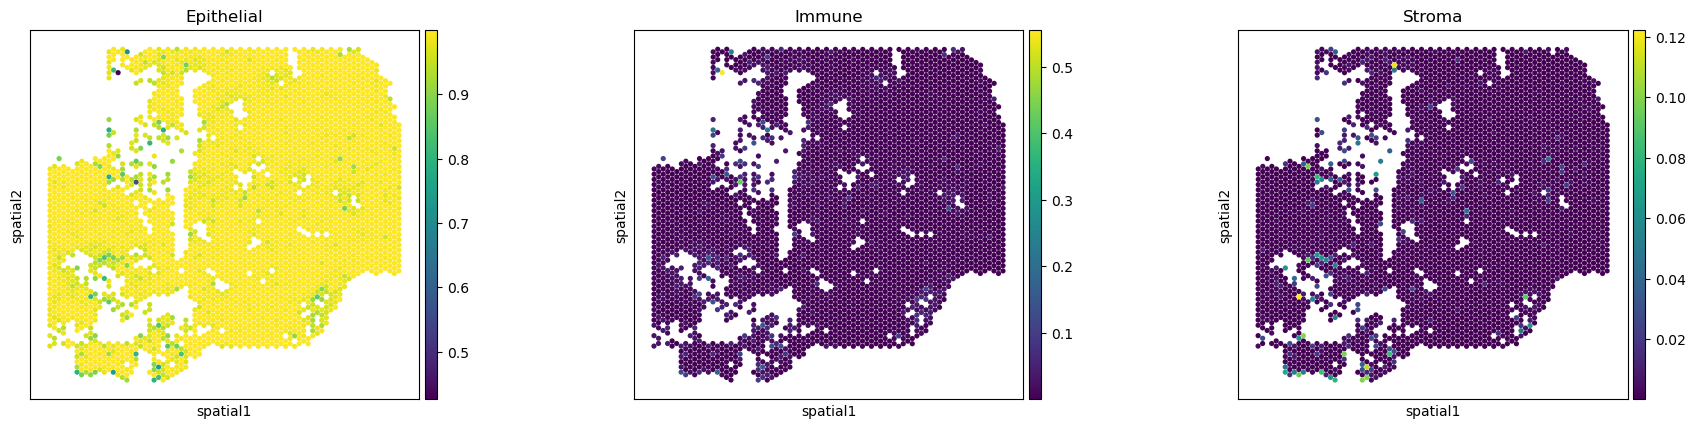

In [141]:
ad_expr = ad_vis.copy()
ad_expr.obs = pd.concat([ad_expr.obs, celltype_portion],axis=1)
sc.pl.spatial(ad_expr, color=['Epithelial','Immune','Stroma'], alpha_img=0, spot_size=400)

## Cytospace

In [218]:
# celltype_portion = pd.read_csv('/home/hmaiwxc/cytospace_results_psd_no_cell_num/fractional_abundances_by_spot.csv', index_col=0)
celltype_portion = pd.read_csv('/home/hmaiwxc/cytospace_results_psd/fractional_abundances_by_spot.csv', index_col=0)

In [219]:
celltype_portion['Immune']=celltype_portion['macrophage']+ \
                                            celltype_portion['Bcell'] + \
                                            celltype_portion['Tcell']
celltype_portion.drop(['macrophage','Bcell','Tcell'],axis=1, inplace=True)
celltype_portion = celltype_portion[['Epithelial', 'Immune', 'Stroma']]

In [220]:
psr = calculate_psr(psr, 'cytospace', raw_deconv, celltype_portion)
mse = calculate_mse(mse, 'cytospace', raw_deconv, celltype_portion)

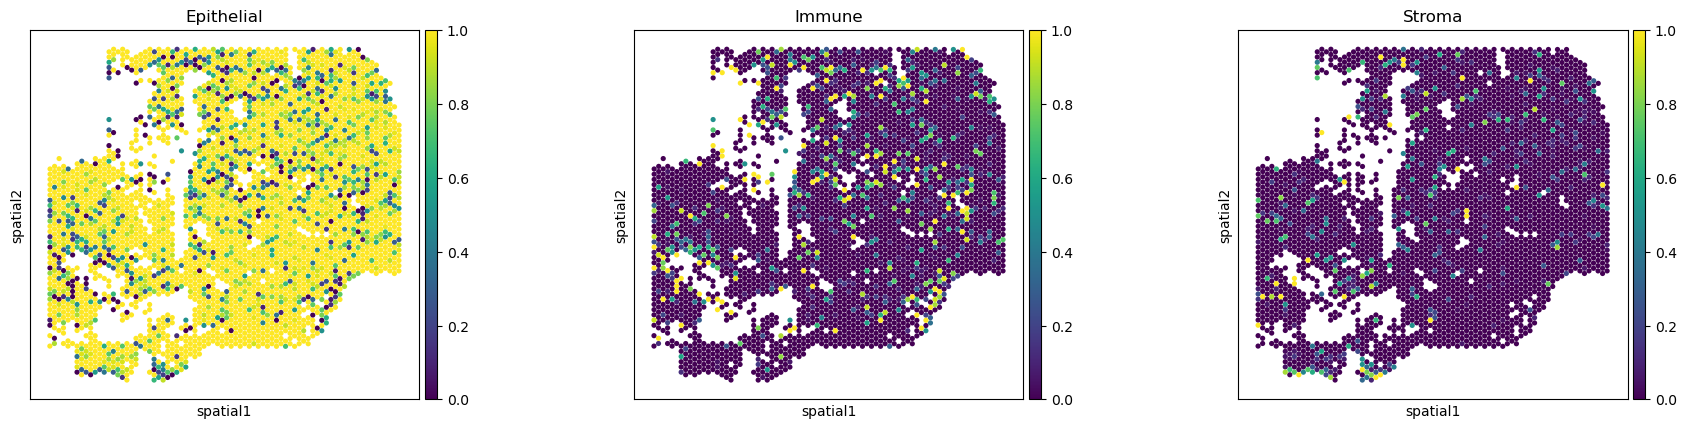

In [146]:
ad_expr = ad_vis.copy()
ad_expr.obs = pd.concat([ad_expr.obs, celltype_portion],axis=1)
sc.pl.spatial(ad_expr, color=['Epithelial','Immune','Stroma'], alpha_img=0, spot_size=400)

## Seurat

In [221]:
celltype_portion = pd.read_csv('/home/hmaiwxc/cytospace_results_psd/Seurat_cellfracs.txt', sep='\t', index_col=0)

In [222]:
celltype_portion['Immune']=celltype_portion['macrophage']+ \
                                            celltype_portion['Bcell'] + \
                                            celltype_portion['Tcell']
celltype_portion.drop(['macrophage','Bcell','Tcell'],axis=1, inplace=True)
celltype_portion = celltype_portion[['Epithelial', 'Immune', 'Stroma']]

In [223]:
psr = calculate_psr(psr, 'seurat', raw_deconv, celltype_portion)
mse = calculate_mse(mse, 'seurat', raw_deconv, celltype_portion)

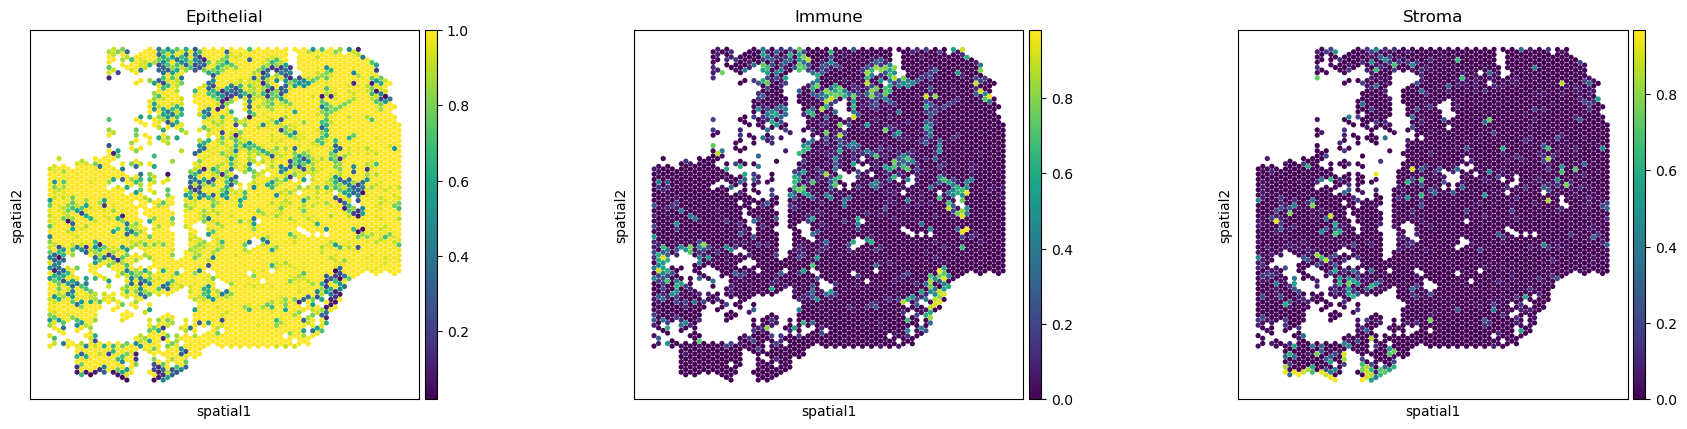

In [150]:
ad_expr = ad_vis.copy()
ad_expr.obs = pd.concat([ad_expr.obs, celltype_portion],axis=1)
sc.pl.spatial(ad_expr, color=['Epithelial','Immune','Stroma'], alpha_img=0, spot_size=400)

## ALL

### PSR

In [224]:
psr

Epithelial    Immune    Stroma
tangram      0.280484  0.379007  0.323307
txt_zs       0.544944  0.547538  0.213671
img_zs       0.683339  0.725858 -0.021279
txt_rb       0.385733  0.532009 -0.070396
img_rb       0.322049  0.427690  0.054470
txt_rt       0.347020  0.381474  0.014002
img_rt       0.565970  0.627211  0.047143
txt_lt       0.528423  0.646517 -0.032069
img_lt       0.661223  0.688769  0.011329
txt_lb       0.536517  0.598860  0.176136
img_lb       0.678874  0.760743 -0.022797
card         0.571602  0.466914  0.443046
cytospace    0.018881  0.008679  0.040846
seurat       0.347560  0.291108  0.498201

In [228]:
psr_sub = psr.loc[['img_lt', 'tangram', 'card','seurat','cytospace'],['Epithelial','Immune','Stroma']]

In [229]:
all_psr_melt = pd.melt(psr_sub, ignore_index=False)

<Axes: xlabel='variable', ylabel='value'>

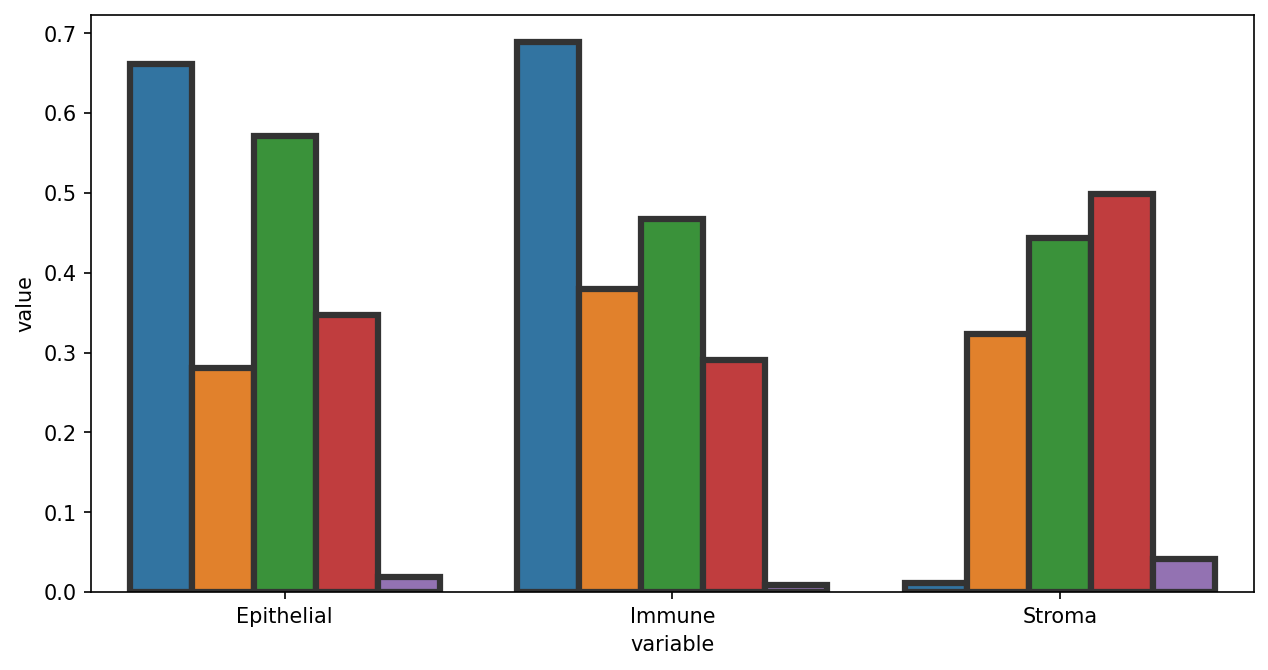

In [230]:
plt.figure(figsize=(10, 5), dpi=150)
sns.barplot(data = all_psr_melt, x='variable',  y='value',hue= all_psr_melt.index, legend=False, edgecolor="0.2", linewidth=3,
)

### MSE

In [231]:
mse

Epithelial    Stroma    Immune
tangram      0.097446  0.016590  0.098856
txt_zs       0.084805  0.030135  0.078633
img_zs       0.067162  0.035314  0.049441
txt_rb       0.120001  0.062755  0.078780
img_rb       0.119006  0.042769  0.088531
txt_rt       0.135817  0.054033  0.107144
img_rt       0.085827  0.043100  0.063178
txt_lt       0.092015  0.031324  0.064483
img_lt       0.093460  0.041115  0.062192
txt_lb       0.100228  0.025114  0.086289
img_lb       0.072173  0.028384  0.050687
card         0.155326  0.021768  0.129515
cytospace    0.188776  0.040414  0.169039
seurat       0.119721  0.018108  0.113377

In [233]:
# mse.to_csv(data_path+'all_mse.csv')

In [234]:
mse = pd.read_csv(data_path+'all_mse.csv', index_col=0)
mse

Epithelial    Stroma    Immune
tangram      0.097446  0.016590  0.098856
txt_zs       0.084805  0.030135  0.078633
img_zs       0.067162  0.035314  0.049441
txt_rb       0.120001  0.062755  0.078780
img_rb       0.119006  0.042769  0.088531
txt_rt       0.135817  0.054033  0.107144
img_rt       0.085827  0.043100  0.063178
txt_lt       0.092015  0.031324  0.064483
img_lt       0.093460  0.041115  0.062192
txt_lb       0.100228  0.025114  0.086289
img_lb       0.072173  0.028384  0.050687
card         0.155326  0.021768  0.129515
cytospace    0.188776  0.040414  0.169039
seurat       0.119721  0.018108  0.113377

In [247]:
mse.loc['img_mean'] = mse.loc[['img_rb', 'img_rt', 'img_lt', 'img_lb']].mean()

In [235]:
mse_sub = mse.loc[['img_lb', 'tangram', 'seurat', 'card','cytospace'], ['Epithelial','Immune','Stroma']]

In [236]:
all_mse_melt = pd.melt(mse_sub, ignore_index=False)

<Axes: xlabel='variable', ylabel='value'>

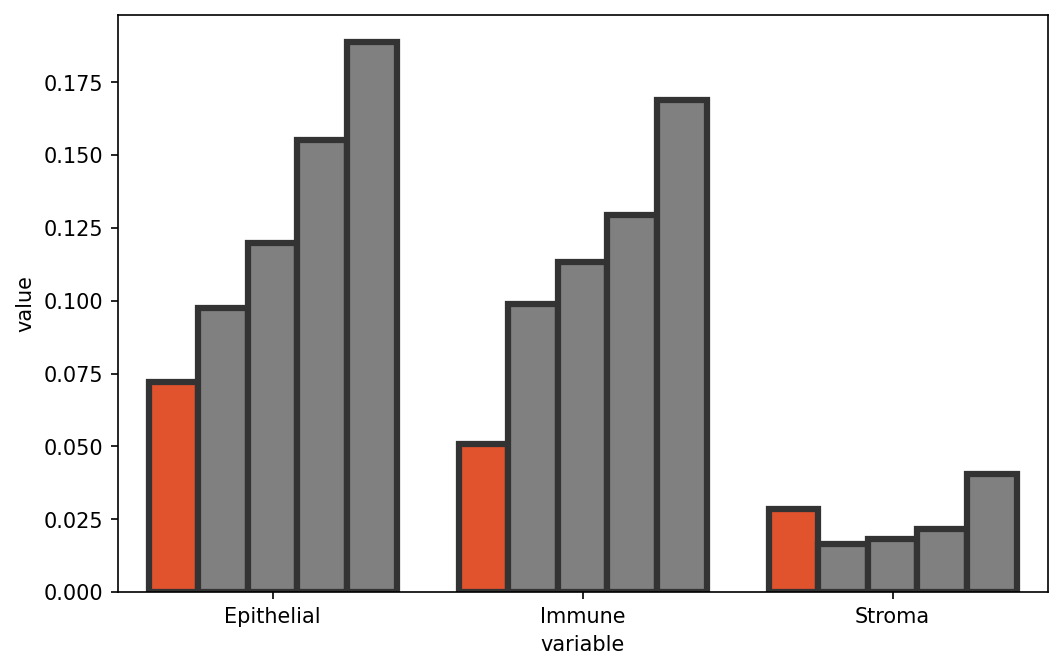

In [237]:
plt.figure(figsize=(8, 5), dpi=150)
sns.barplot(data = all_mse_melt, x='variable',  y='value',hue= all_mse_melt.index, legend=False, edgecolor="0.2", linewidth=3,
            palette=['#FE420F','grey','grey', 'grey', 'grey']
)

In [248]:
mse_sub = mse.loc[['img_mean', 'tangram', 'seurat', 'card','cytospace']]

In [249]:
all_mse_melt = pd.melt(mse_sub, ignore_index=False)

<Axes: xlabel='variable', ylabel='value'>

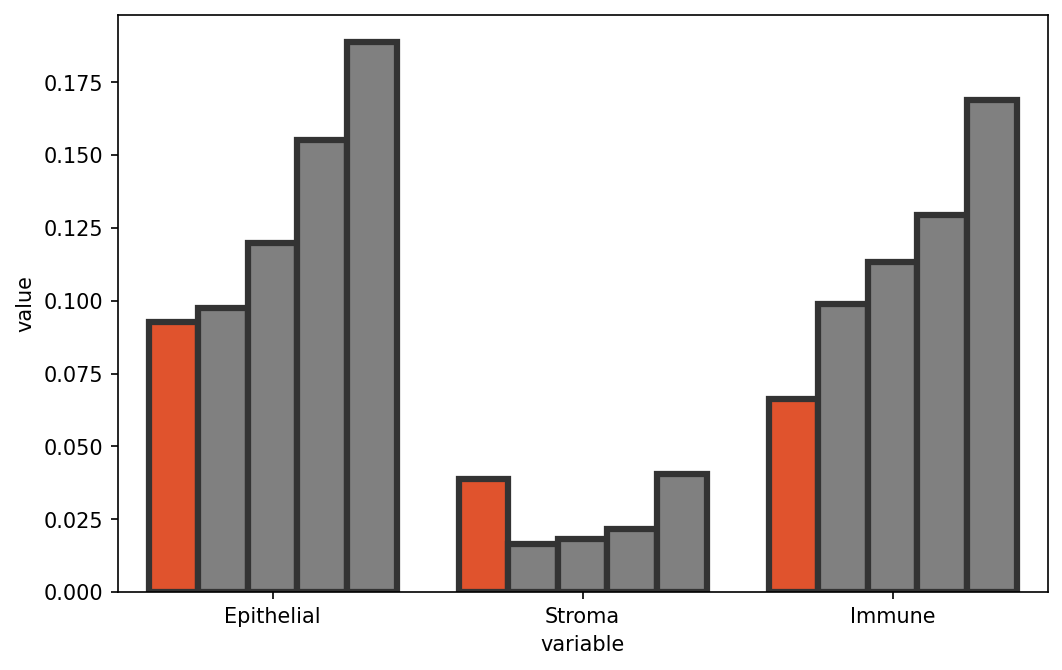

In [250]:
plt.figure(figsize=(8, 5), dpi=150)
sns.barplot(data = all_mse_melt, x='variable',  y='value',hue= all_mse_melt.index, legend=False, edgecolor="0.2", linewidth=3,
            palette=['#FE420F','grey','grey', 'grey', 'grey']
)